# House Prices Prediction

### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import missingno as msno
import tensorflow as tf
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor
from keras import Sequential, optimizers, metrics
from keras.layers import Dense, Dropout, Input

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Read the data that will be used to select the model

In [2]:
# Import the data
folder = os.getcwd()
df = pd.read_csv(os.path.join(folder, "train.csv"))
df.shape

(1460, 81)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
df = df.drop(columns="Id")

In [5]:
df.duplicated().sum()

0

In [6]:
df[df.columns[df.isnull().any()]].isna().sum()

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

### Missing Data

Anaysis of the missing data pattern

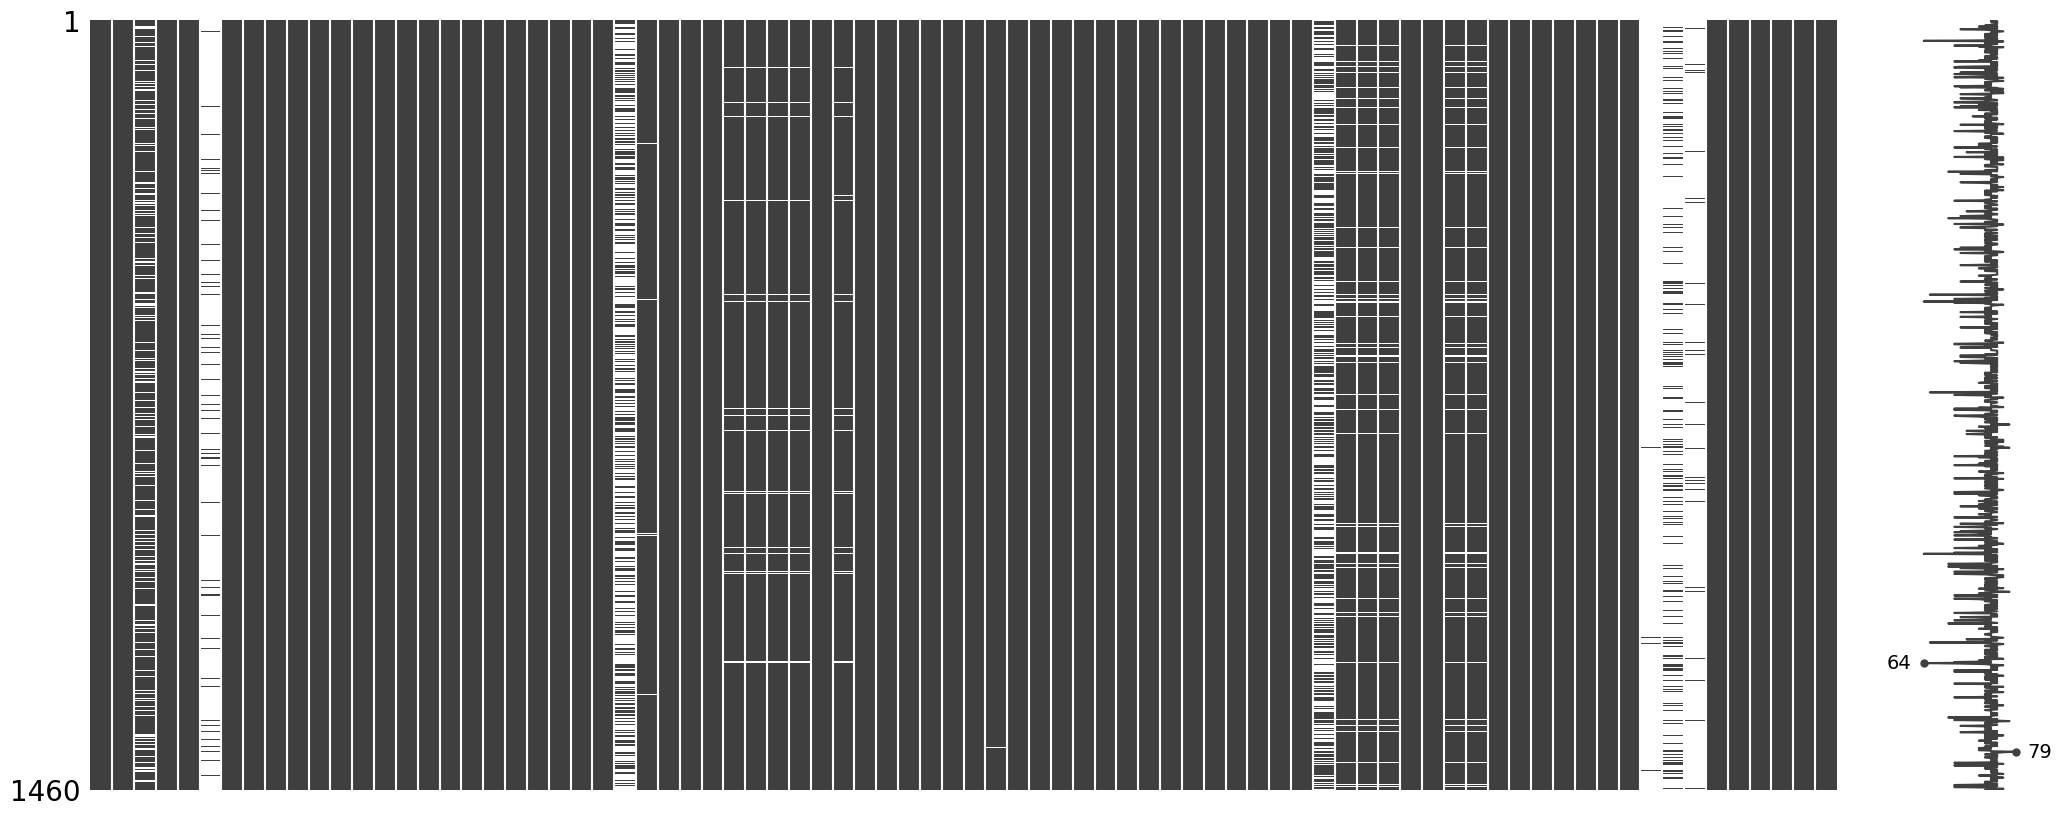

In [7]:
msno.matrix(df)
plt.show()

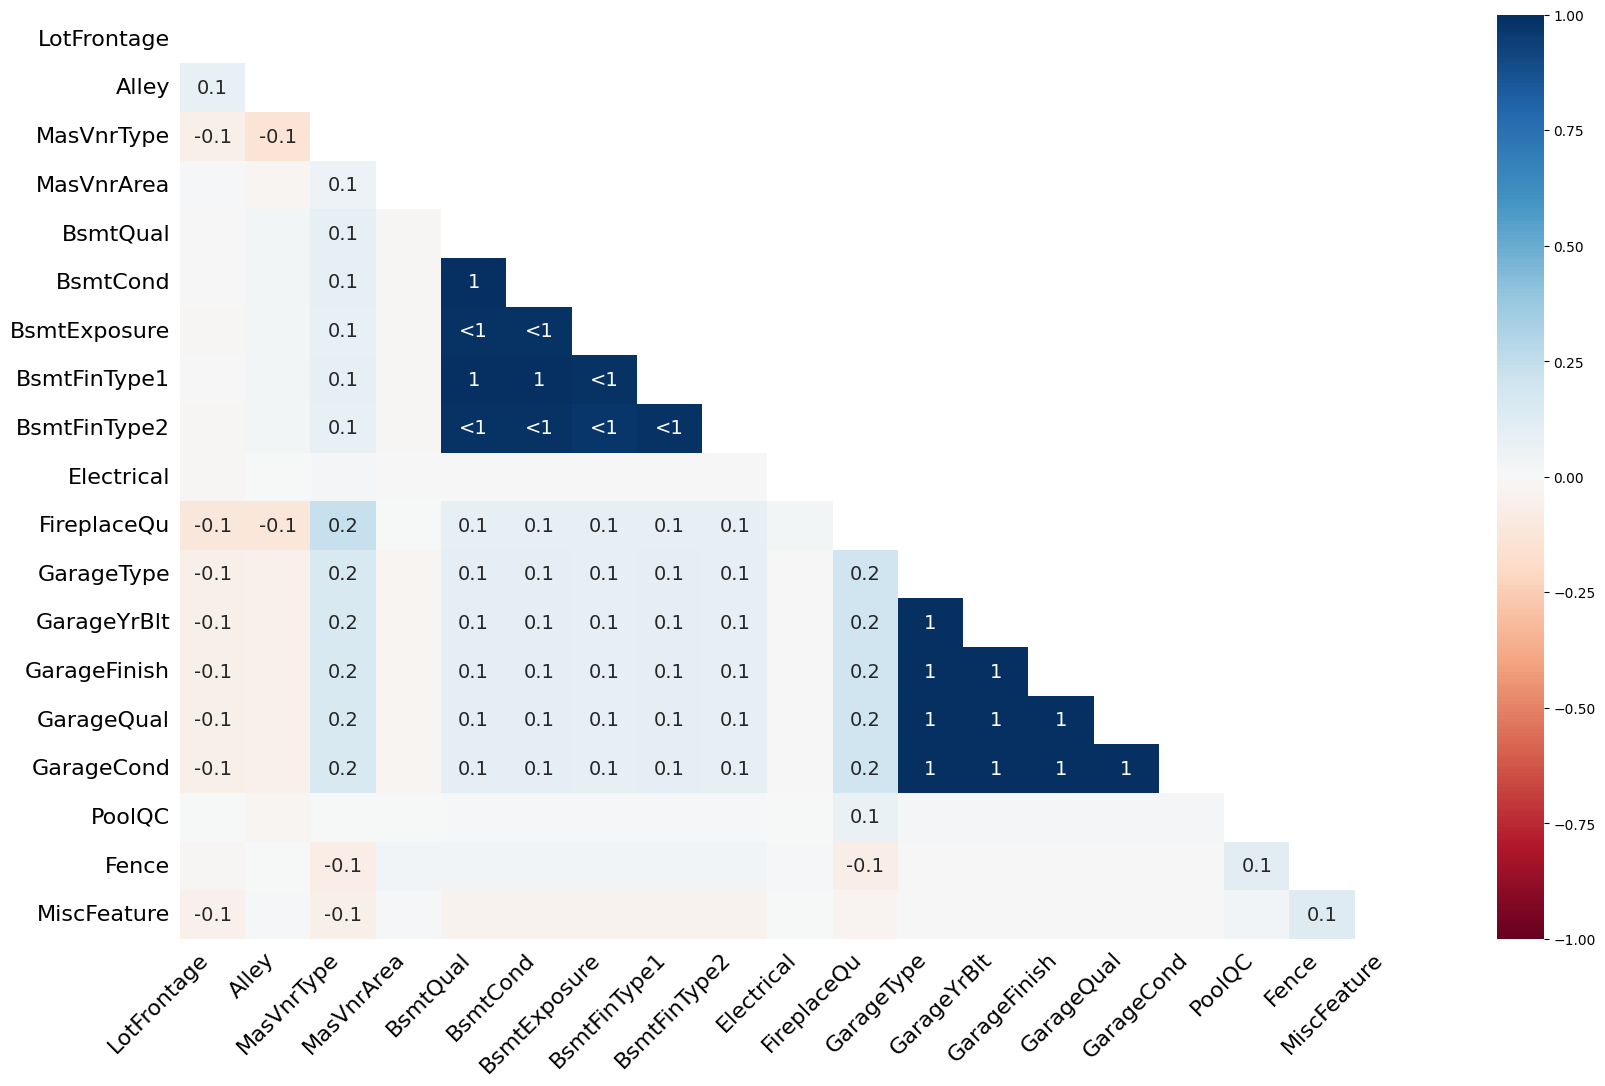

In [8]:
msno.heatmap(df)
plt.show()

Imputation of the missing data

In [9]:
# LotFrontage: Linear feet of street connected to property
print(df["LotFrontage"].isna().sum() / df.shape[0] * 100)
# assumption: NAs == no street connected to property
df["LotFrontage"] = df["LotFrontage"].fillna(0)

17.73972602739726


In [10]:
# Alley: Type of alley access
print(df["Alley"].isna().sum() / df.shape[0] * 100)
print(df["Alley"].unique())
# 93.77% of Nas -> rm NAs
df = df.drop(columns="Alley")

93.76712328767123
[nan 'Grvl' 'Pave']


In [11]:
# MasVnrType: Masonry veneer type
print(df["MasVnrType"].isna().sum() / df.shape[0] * 100)
print(df["MasVnrType"].unique())
# use a place holder
df["MasVnrType"] = df["MasVnrType"].fillna("Unknown")

59.726027397260275
['BrkFace' nan 'Stone' 'BrkCmn']


In [12]:
# MasVnrArea: Masonry veneer type
print(df["MasVnrArea"].isna().sum() / df.shape[0] * 100)
# assumption: NAs == no Masonry veneer
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

0.547945205479452


In [13]:
# Bsmt
print(df["BsmtQual"].isna().sum() / df.shape[0] * 100)
print(df["BsmtQual"].unique())
# use a place holder
df["BsmtQual"] = df["BsmtQual"].fillna("Unknown")
df["BsmtCond"] = df["BsmtCond"].fillna("Unknown")
df["BsmtExposure"] = df["BsmtExposure"].fillna("Unknown")
df["BsmtFinType1"] = df["BsmtFinType1"].fillna("Unknown")
df["BsmtFinType2"] = df["BsmtFinType2"].fillna("Unknown")


2.5342465753424657
['Gd' 'TA' 'Ex' nan 'Fa']


In [14]:
# Electrical
print(df["Electrical"].isna().sum() / df.shape[0] * 100)
print(df["Electrical"].unique())
# use a place holder
df["Electrical"] = df["Electrical"].fillna("Unknown")

0.0684931506849315
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]


In [15]:
# FireplaceQu
print(df["FireplaceQu"].isna().sum() / df.shape[0] * 100)
print(df["FireplaceQu"].unique())
# use a place holder
df["FireplaceQu"] = df["FireplaceQu"].fillna("Unknown")

47.26027397260274
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']


In [16]:
# Garage
print(df["GarageType"].isna().sum() / df.shape[0] * 100)
print(df["GarageType"].unique())
# use a place holder
df["GarageType"] = df["GarageType"].fillna("NoGarage")
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(9999)
df["GarageFinish"] = df["GarageFinish"].fillna("NoGarage")
df["GarageQual"] = df["GarageQual"].fillna("NoGarage")
df["GarageCond"] = df["GarageCond"].fillna("NoGarage")

5.5479452054794525
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']


In [17]:
# PoolQC
print(df["PoolQC"].isna().sum() / df.shape[0] * 100)
print(df["PoolQC"].unique())
# use a place holder
df["PoolQC"] = df["PoolQC"].fillna("NoPool")

99.52054794520548
[nan 'Ex' 'Fa' 'Gd']


In [18]:
# Fence
print(df["Fence"].isna().sum() / df.shape[0] * 100)
print(df["Fence"].unique())
# use a place holder
df["Fence"] = df["Fence"].fillna("NoFence")

80.75342465753424
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


In [19]:
# MiscFeature
print(df["MiscFeature"].isna().sum() / df.shape[0] * 100)
print(df["MiscFeature"].unique())
# use a place holder
df["MiscFeature"] = df["MiscFeature"].fillna("NoMiscFeature")

96.30136986301369
[nan 'Shed' 'Gar2' 'Othr' 'TenC']


### Exploratory Analysis

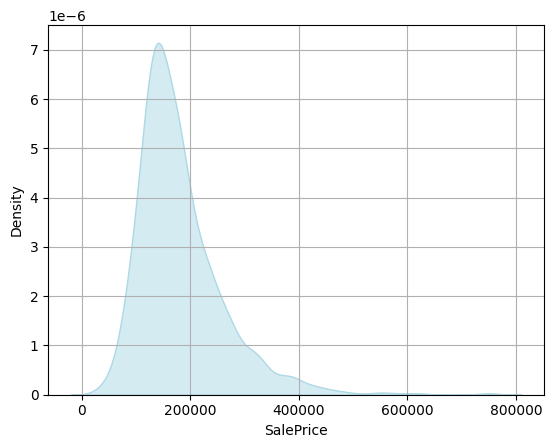

In [20]:
# Empiric distribution of the response variable
sns.kdeplot(df["SalePrice"], color="lightblue", fill=True, alpha=0.5)
plt.xlabel("SalePrice")
plt.ylabel("Density")
plt.grid()
plt.show()

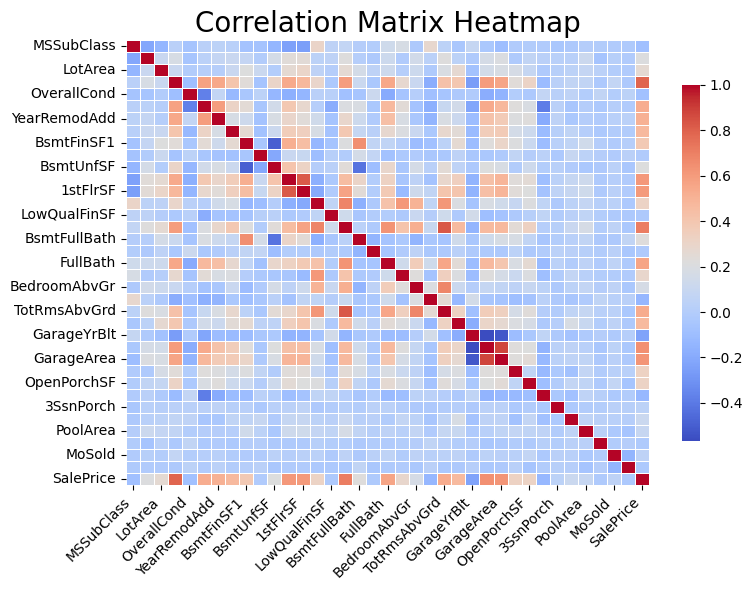

In [21]:
# Heatmap of the correlation matrix for quantitative variables
numeric_df = df.select_dtypes(include=["int64", "float64"])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix Heatmap", fontsize=20)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

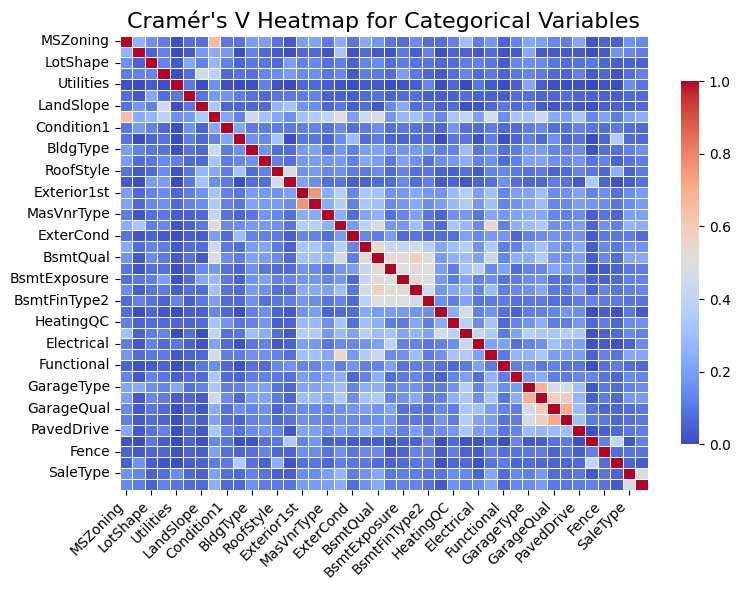

In [22]:
# Heatmap of Cramer's V for qualitative variables
nominal_df = df.select_dtypes(include=["object"])
nominal_df

# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))


vcramer_matrix = pd.DataFrame(
    index=nominal_df.columns, columns=nominal_df.columns
)

for var1 in nominal_df.columns:
    for var2 in nominal_df.columns:
        if var1 == var2:
            vcramer_matrix.loc[var1, var2] = 1  
        else:
            confusion_matrix = pd.crosstab(df[var1], df[var2])
            vcramer_matrix.loc[var1, var2] = cramers_v(confusion_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(
    vcramer_matrix.astype(float),
    annot=False,
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Cramér's V Heatmap", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

### Modelling

Data preparation for the Modelling Phase

In [23]:
# lable encoding
label_encoder = LabelEncoder()

for var in nominal_df.columns:
    df[var] = label_encoder.fit_transform(df[var])

In [24]:
# Training and Testing df split
X_df = df.drop(columns='SalePrice')
y_df = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.25, random_state=22)

In [25]:
# Training and Testing df without multicollinear variables 
high_corr_vars = np.where(np.abs(correlation_matrix) > 0.8)
high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y]) for x, y in zip(*high_corr_vars) if x != y and x < y]

high_cramers_v_vars = np.where(np.abs(vcramer_matrix) > 0.8)
high_cramers_pairs = [(vcramer_matrix.index[x], vcramer_matrix.columns[y]) for x, y in zip(*high_cramers_v_vars) if x != y and x < y]

X_train_red = X_train.drop(columns = ['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageArea'])
X_test_red = X_test.drop(columns = ['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageArea'])

In [26]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_red_scaled = scaler.fit_transform(X_train_red)
X_test_red_scaled = scaler.transform(X_test_red)

Linear Model

In [27]:
lm = LinearRegression()
lm.fit(X_train_red, y_train)
y_pred_lm = lm.predict(X_test_red)
rmse_lm = np.sqrt(mean_squared_error(np.log(y_test + 1), np.log(y_pred_lm*1)))

results = pd.DataFrame()
results = pd.concat([results, pd.DataFrame({'Model': ['LM'], 'RMSE': [rmse_lm]})], ignore_index=True)

Ridge with 5-fold Cross Validation

In [28]:
param_grid_ridge = {
    'alpha': np.logspace(-3, 3, 7)  # Values from 0.001 to 1000
}

grid_search = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_red_scaled, y_train)
best_alpha = grid_search.best_params_['alpha']

ridge_model = Ridge(alpha = best_alpha)
ridge_model.fit(X_train_red_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_red_scaled)
rmse_ridge = np.sqrt(mean_squared_error(np.log(y_test + 1), np.log(y_pred_ridge*1)))
results = pd.concat([results, pd.DataFrame({'Model': ['Ridge'], 'RMSE': [rmse_ridge]})], ignore_index=True)

Lasso with 5-fold Cross Validation

In [29]:
param_grid_lasso = {
    'alpha': np.logspace(-3, 3, 7)  # Values from 0.001 to 1000
}

grid_search = GridSearchCV(Lasso(max_iter=10000), param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_red_scaled, y_train)
best_alpha = grid_search.best_params_['alpha']

lasso_model = Lasso(alpha = best_alpha, max_iter=10000)
lasso_model.fit(X_train_red_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_red_scaled)
rmse_lasso = np.sqrt(mean_squared_error(np.log(y_test + 1), np.log(y_pred_lasso*1)))
results = pd.concat([results, pd.DataFrame({'Model': ['Lasso'], 'RMSE': [rmse_lasso]})], ignore_index=True)

Random Forest with 5-fold Cross Validation

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],        
    'max_depth': [None, 10, 20, 30],      
    'min_samples_split': [2, 5, 10],       
    'min_samples_leaf': [1, 2, 4]       
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=125, warm_start=True), param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_

rf_model = RandomForestRegressor(**best_params, random_state=125)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(np.log(y_test + 1), np.log(y_pred_rf*1)))
results = pd.concat([results, pd.DataFrame({'Model': ['Random Forest'], 'RMSE': [rmse_rf]})], ignore_index=True)

Gradient Boosting with 5-fold Cross Validation

In [ ]:
param_grid_gb = {
    'n_estimators': [100, 200, 300],        
    'learning_rate': [0.01, 0.05, 0.1],     
    'max_depth': [3, 4, 5],                 
    'min_samples_split': [2, 5, 10],        
    'subsample': [0.8, 1.0, 1.5]         
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=65), param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error', 
                           verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_

gbm_model = GradientBoostingRegressor(**best_params, random_state=65)
gbm_model.fit(X_train_scaled, y_train)
y_pred_gbm= gbm_model.predict(X_test_scaled)
rmse_gbm = np.sqrt(mean_squared_error(np.log(y_test + 1), np.log(y_pred_gbm*1)))
results = pd.concat([results, pd.DataFrame({'Model': ['Gradient Boosting Machines'], 'RMSE': [rmse_gbm]})], ignore_index=True)

Artificial Neural Network with 5-fold Cross Validation

In [ ]:
# Define the model
def create_model(activation,learn_rate,dropout_rate,neurons):

    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)) )  
    model.add(Dense(neurons, activation=activation))   
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error',
                optimizer=optimizers.Adam(learning_rate=learn_rate),
                metrics=[metrics.RootMeanSquaredError()])
    return model


# Define the parameters grid
activation =  ['relu','selu', 'elu', 'linear', 'tanh']
learn_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
dropout_rate = [0.0, 0.1, 0.2, 0.3]
neurons = [1, 5, 10, 20]
epochs = [10, 20, 100, 200, 300]
batch_size = [50, 100, 500, 1000]

param_grid_ann = dict(activation=activation, 
    learn_rate=learn_rate, 
    dropout_rate=dropout_rate,
    neurons=neurons, 
    epochs=epochs, 
    batch_size=batch_size)

ann_model = KerasRegressor(model=create_model, 
    neurons=neurons, 
    learn_rate=learn_rate, 
    dropout_rate=dropout_rate,
    activation=activation)

opt = RandomizedSearchCV(
    ann_model,
    param_distributions=param_grid_ann,
    cv=KFold(n_splits=5, shuffle=True, random_state=27),
    scoring='neg_root_mean_squared_error',
    n_iter=150,
    random_state=123,
    n_jobs=-1
)
  
best_model = opt.fit(X_train_scaled, y_train).best_estimator_
y_pred_ann = best_model.predict(X_test_scaled)
rmse_ann = np.sqrt(mean_squared_error(np.log(y_test + 1), np.log(y_pred_ann*1)))
results = pd.concat([results, pd.DataFrame({'Model': ['ANN'], 'RMSE': [rmse_ann]})], ignore_index=True)

In [ ]:
print(results)

### Predictions

In [ ]:
to_predict = pd.read_csv(os.path.join(folder, "test.csv"))
to_predict